In [ ]:
# ============================================
# 📌 1. Install + Import Libraries
# ============================================
!pip install tensorflow pandas numpy matplotlib seaborn scikit-learn statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, Flatten
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (16,6),
    "font.size": 16,
    "axes.labelsize": 18,
    "axes.titlesize": 20,
    "legend.fontsize": 16,
    "figure.dpi": 200
})

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# ============================================
# 📌 2. Load Dataset
# ============================================
df = pd.read_csv("/content/final_cleaned_interpolated.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime").sort_index()
df = df.dropna()

print(df.head())
print(df.info())

                     temperature_2m  relative_humidity_2m  surface_pressure  \
datetime                                                                      
2020-11-25 01:00:00            10.0                    88             872.4   
2020-11-25 02:00:00             9.6                    87             871.9   
2020-11-25 03:00:00             9.5                    86             871.5   
2020-11-25 04:00:00             9.2                    85             871.3   
2020-11-25 05:00:00             8.4                    89             870.9   

                     pressure_msl  precipitation  cloudcover  windspeed_10m  \
datetime                                                                      
2020-11-25 01:00:00        1018.3            0.0           3            2.5   
2020-11-25 02:00:00        1018.0            0.0           3            2.2   
2020-11-25 03:00:00        1017.6            0.0           0            2.5   
2020-11-25 04:00:00        1017.5            0.0   

In [ ]:
# ============================================
# 📌 3. Feature Engineering
# ============================================

# Add time features
df["hour"] = df.index.hour
df["month"] = df.index.month
df["dayofweek"] = df.index.dayofweek

# Cyclic encoding for smooth periodicity
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

# Exogenous features for forecasting
feature_cols = [
    "pm2_5_ugm3", "pm10_ugm3", "co_ppm", "no2_ppb", "o3_ppm", "so2_ppb",
    "temperature_2m", "relative_humidity_2m", "surface_pressure",
    "precipitation", "cloudcover", "windspeed_10m",
    "hour", "month", "hour_sin", "hour_cos", "month_sin", "month_cos"
]

In [ ]:
# ============================================
# 📌 4. Train / Validation / Test Split
# ============================================

train_size = 0.8
valid_size = 0.1
n = len(df)
train_end = int(n * train_size)
valid_end = int(n * (train_size + valid_size))

train = df.iloc[:train_end]
valid = df.iloc[train_end:valid_end]
test  = df.iloc[valid_end:]

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train[feature_cols])
X_valid = scaler_X.transform(valid[feature_cols])
X_test  = scaler_X.transform(test[feature_cols])

y_train = scaler_y.fit_transform(train[["AQI"]])
y_valid = scaler_y.transform(valid[["AQI"]])
y_test  = scaler_y.transform(test[["AQI"]])

print("Train/Valid/Test shapes:", X_train.shape, X_valid.shape, X_test.shape)

Train/Valid/Test shapes: (34449, 18) (4306, 18) (4307, 18)


In [ ]:
# ============================================
# 📌 5. Create Sequences for Transformer
# ============================================

SEQ_LEN = 24  # use past 24 hours to predict next AQI

def create_sequences(X, y, seq_len=SEQ_LEN):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_valid_seq, y_valid_seq = create_sequences(X_valid, y_valid)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test)

print("Sequence shapes:", X_train_seq.shape, y_train_seq.shape)

Sequence shapes: (34425, 24, 18) (34425, 1)


In [ ]:
# ============================================
# 📌 6. Build Transformer Time Series Model
# ============================================

def transformer_block(inputs, head_size=32, num_heads=4, ff_dim=64, dropout=0.2):
    # Multi-Head Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    # Feed Forward
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)

    out2 = Add()([out1, ff_output])
    out2 = LayerNormalization(epsilon=1e-6)(out2)
    return out2

input_layer = Input(shape=(SEQ_LEN, len(feature_cols)))
x = transformer_block(input_layer, head_size=32, num_heads=4, ff_dim=64)
x = Flatten()(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 18)    │      9,618 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 18)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 18)    │          0 │ input_layer[0][0… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 18)    │         36 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24, 64)    │      1,216 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 24, 18)    │      1,170 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 18)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 18)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 18)    │         36 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 432)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        433 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,509 (48.86 KB)

 Trainable params: 12,509 (48.86 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================================
# 📌 7. Train Transformer Model
# ============================================

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_valid_seq, y_valid_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0892 - mae: 0.2146 - val_loss: 0.0094 - val_mae: 0.0741
Epoch 2/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0119 - mae: 0.0805 - val_loss: 0.0069 - val_mae: 0.0616
Epoch 3/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0084 - mae: 0.0655 - val_loss: 0.0071 - val_mae: 0.0657
Epoch 4/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0068 - mae: 0.0584 - val_loss: 0.0055 - val_mae: 0.0552
Epoch 5/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0058 - mae: 0.0542 - val_loss: 0.0063 - val_mae: 0.0608
Epoch 6/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0053 - mae: 0.0501 - val_loss: 0.0042 - val_mae: 0.0480
Epoch 7/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0051 - mae: 0.0490 - val_loss: 0.0040 - val_mae: 0.0466
Epoch 8/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0045 - mae: 0.0456 - val_loss: 0.0039 - val_mae: 0.0426
Epoch 9/50
1076/1076 ━━━━━━━━━━━━━━━

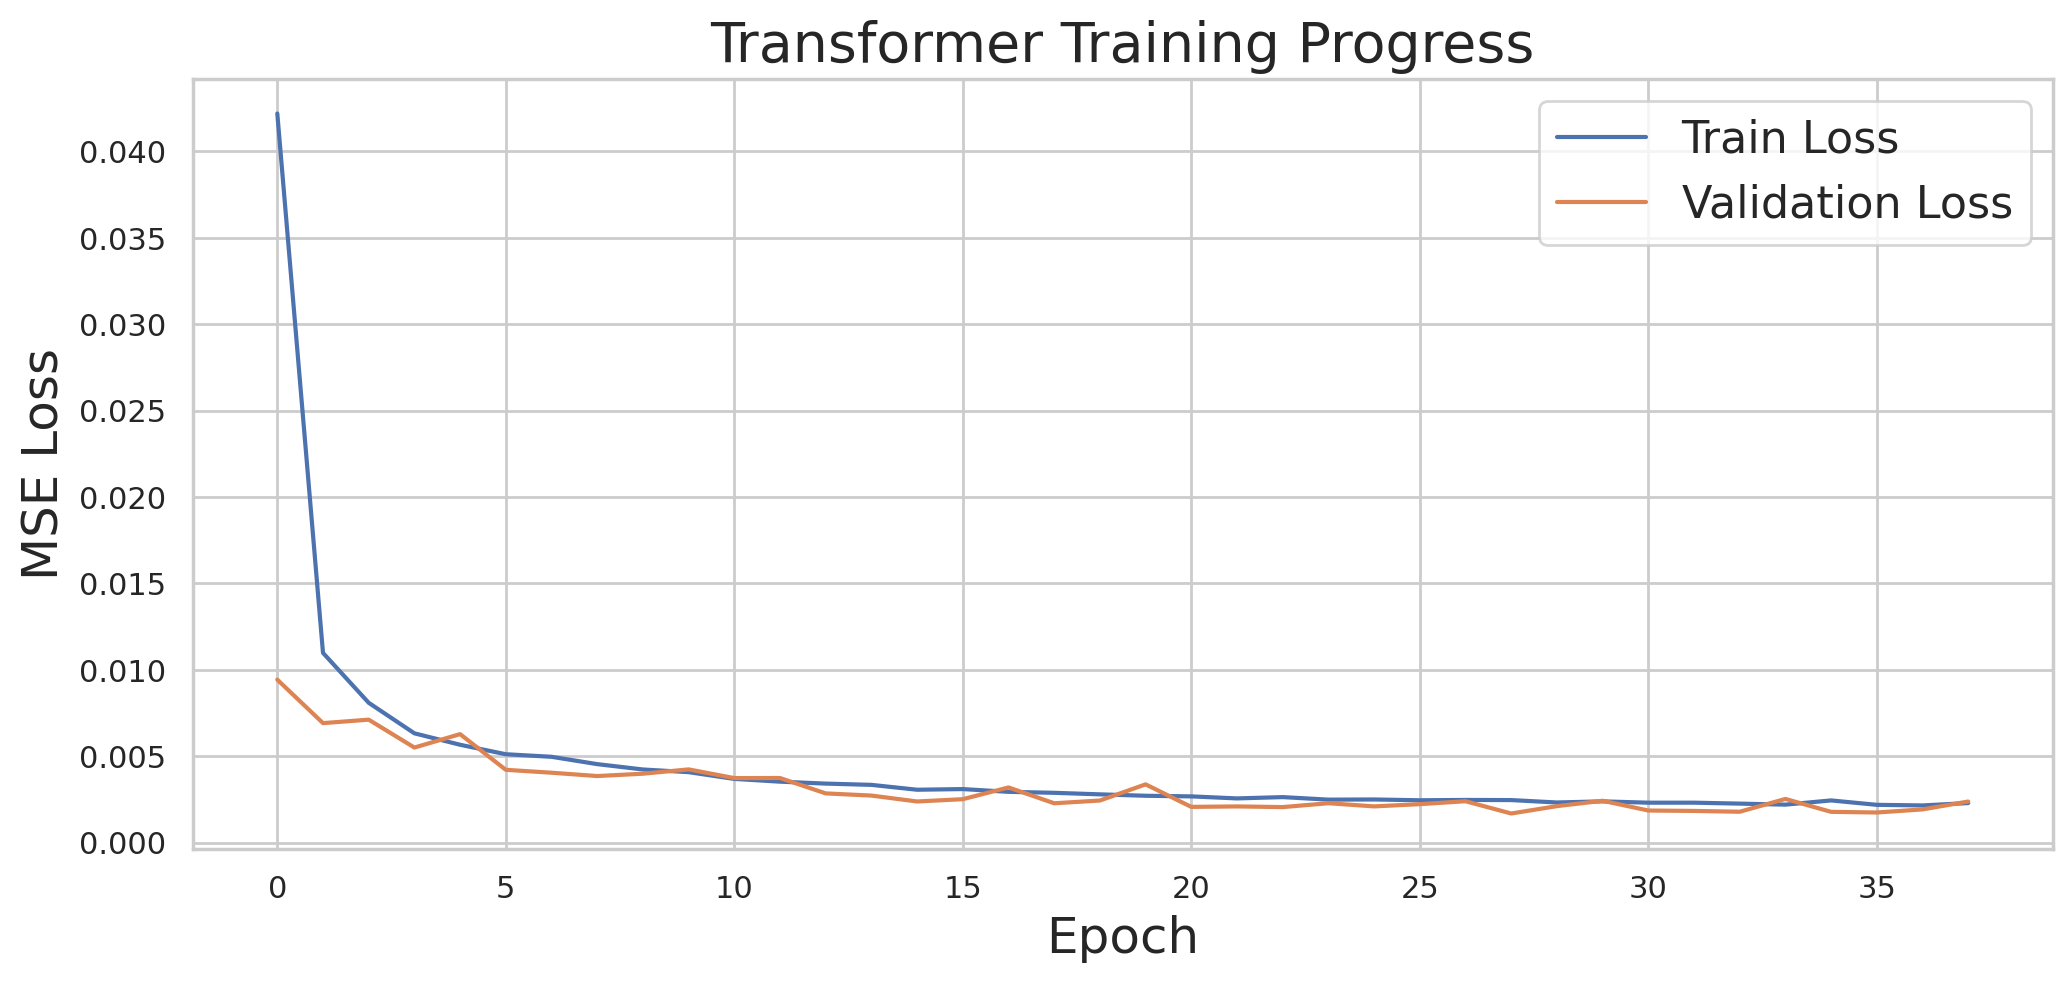

In [ ]:
# ============================================
# 📌 8. Plot Training Progress
# ============================================

plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Transformer Training Progress")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ============================================
# 📌 9. Predictions & Inverse Scaling
# ============================================

def inverse_scale(y_scaled):
    return scaler_y.inverse_transform(y_scaled)

y_valid_pred = inverse_scale(model.predict(X_valid_seq))
y_test_pred  = inverse_scale(model.predict(X_test_seq))
y_valid_true = inverse_scale(y_valid_seq)
y_test_true  = inverse_scale(y_test_seq)

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
# ============================================
# 📌 10. Evaluation Metrics
# ============================================

def evaluate(true, pred, label="Set"):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"📌 {label} Evaluation")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"R²   = {r2:.4f}")
    print("--------------------------------------")
    return mae, rmse, r2

evaluate(y_valid_true, y_valid_pred, "Validation")
evaluate(y_test_true, y_test_pred, "Test")

📌 Validation Evaluation
MAE  = 13.3044
RMSE = 20.0150
R²   = 0.9156
--------------------------------------
📌 Test Evaluation
MAE  = 11.3740
RMSE = 15.3013
R²   = 0.9034
--------------------------------------


(11.373974563666142, np.float64(15.301270735915054), 0.9033723794418501)

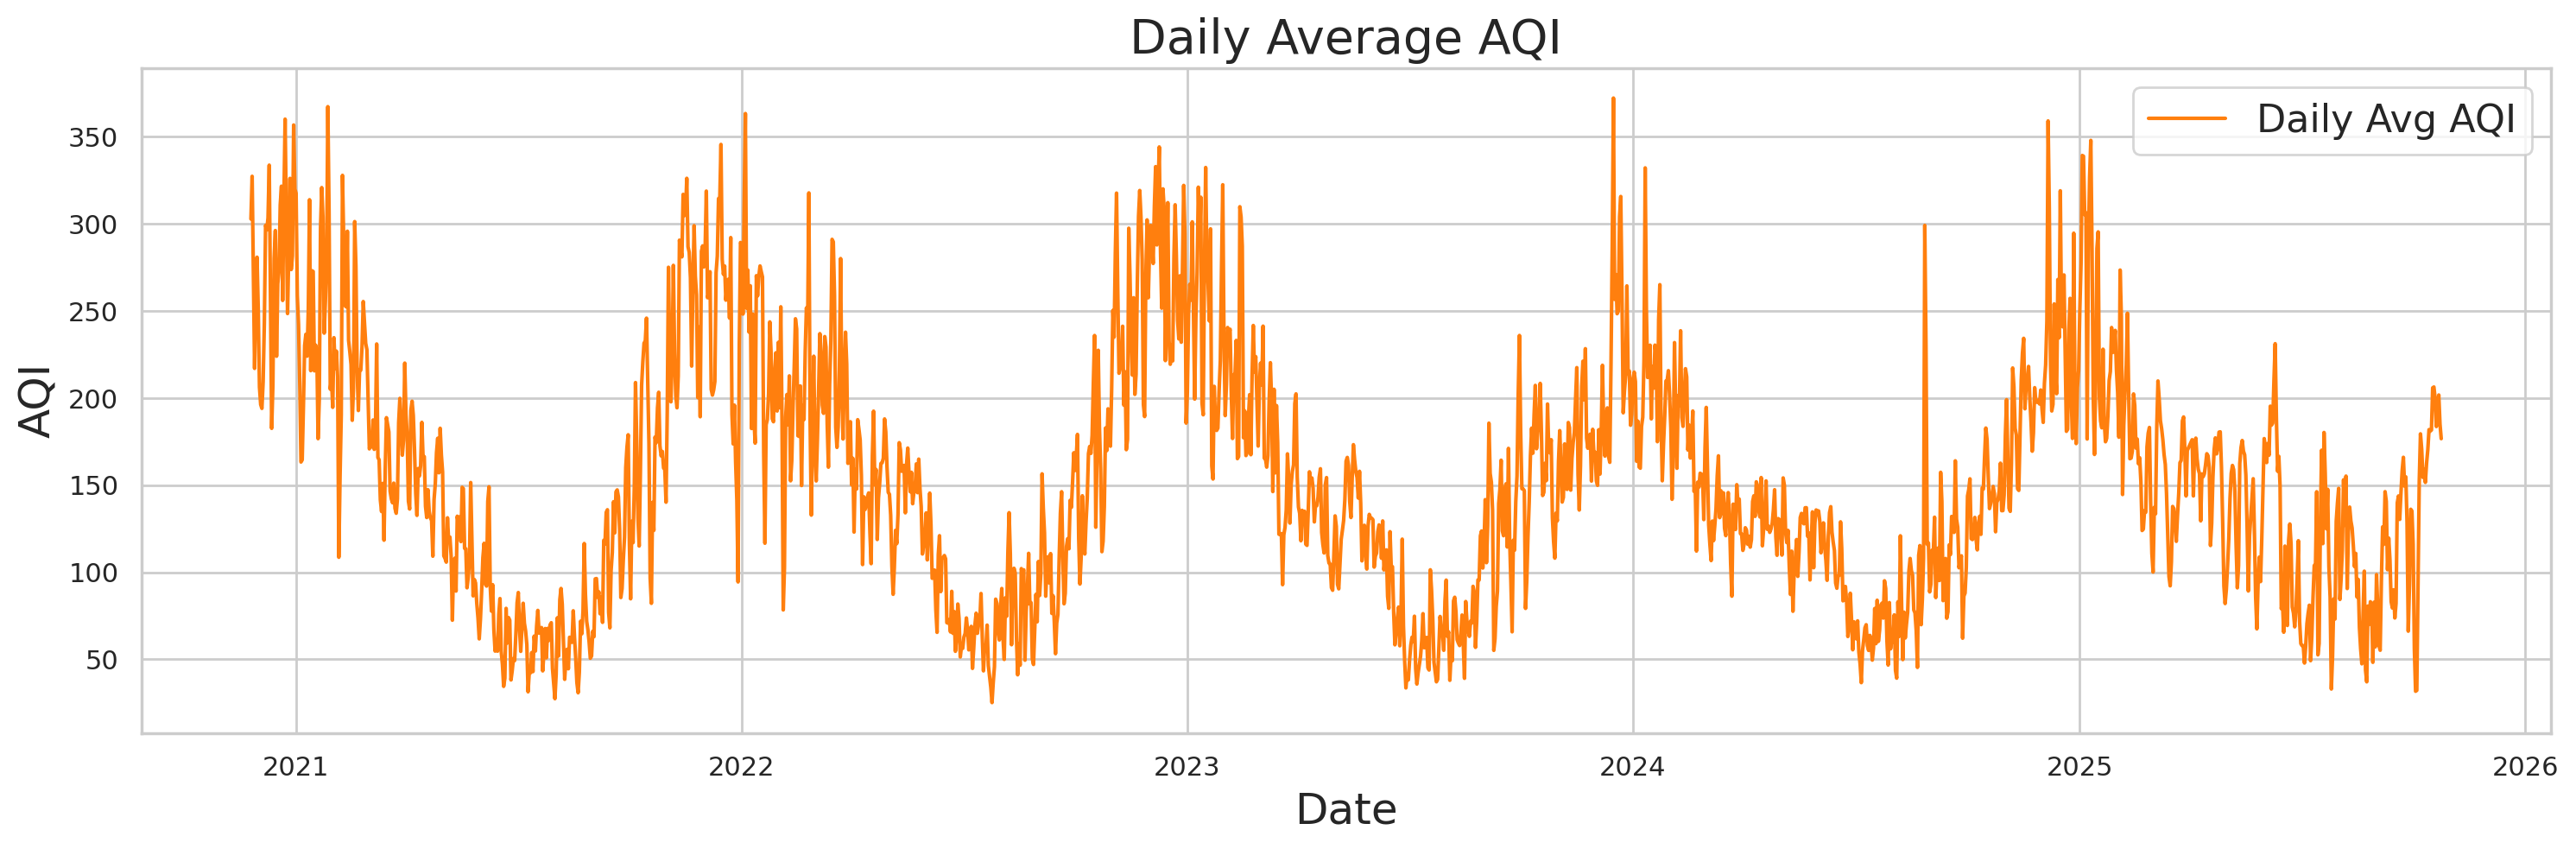

/tmp/ipython-input-4167827242.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df['AQI'].resample('M').mean()


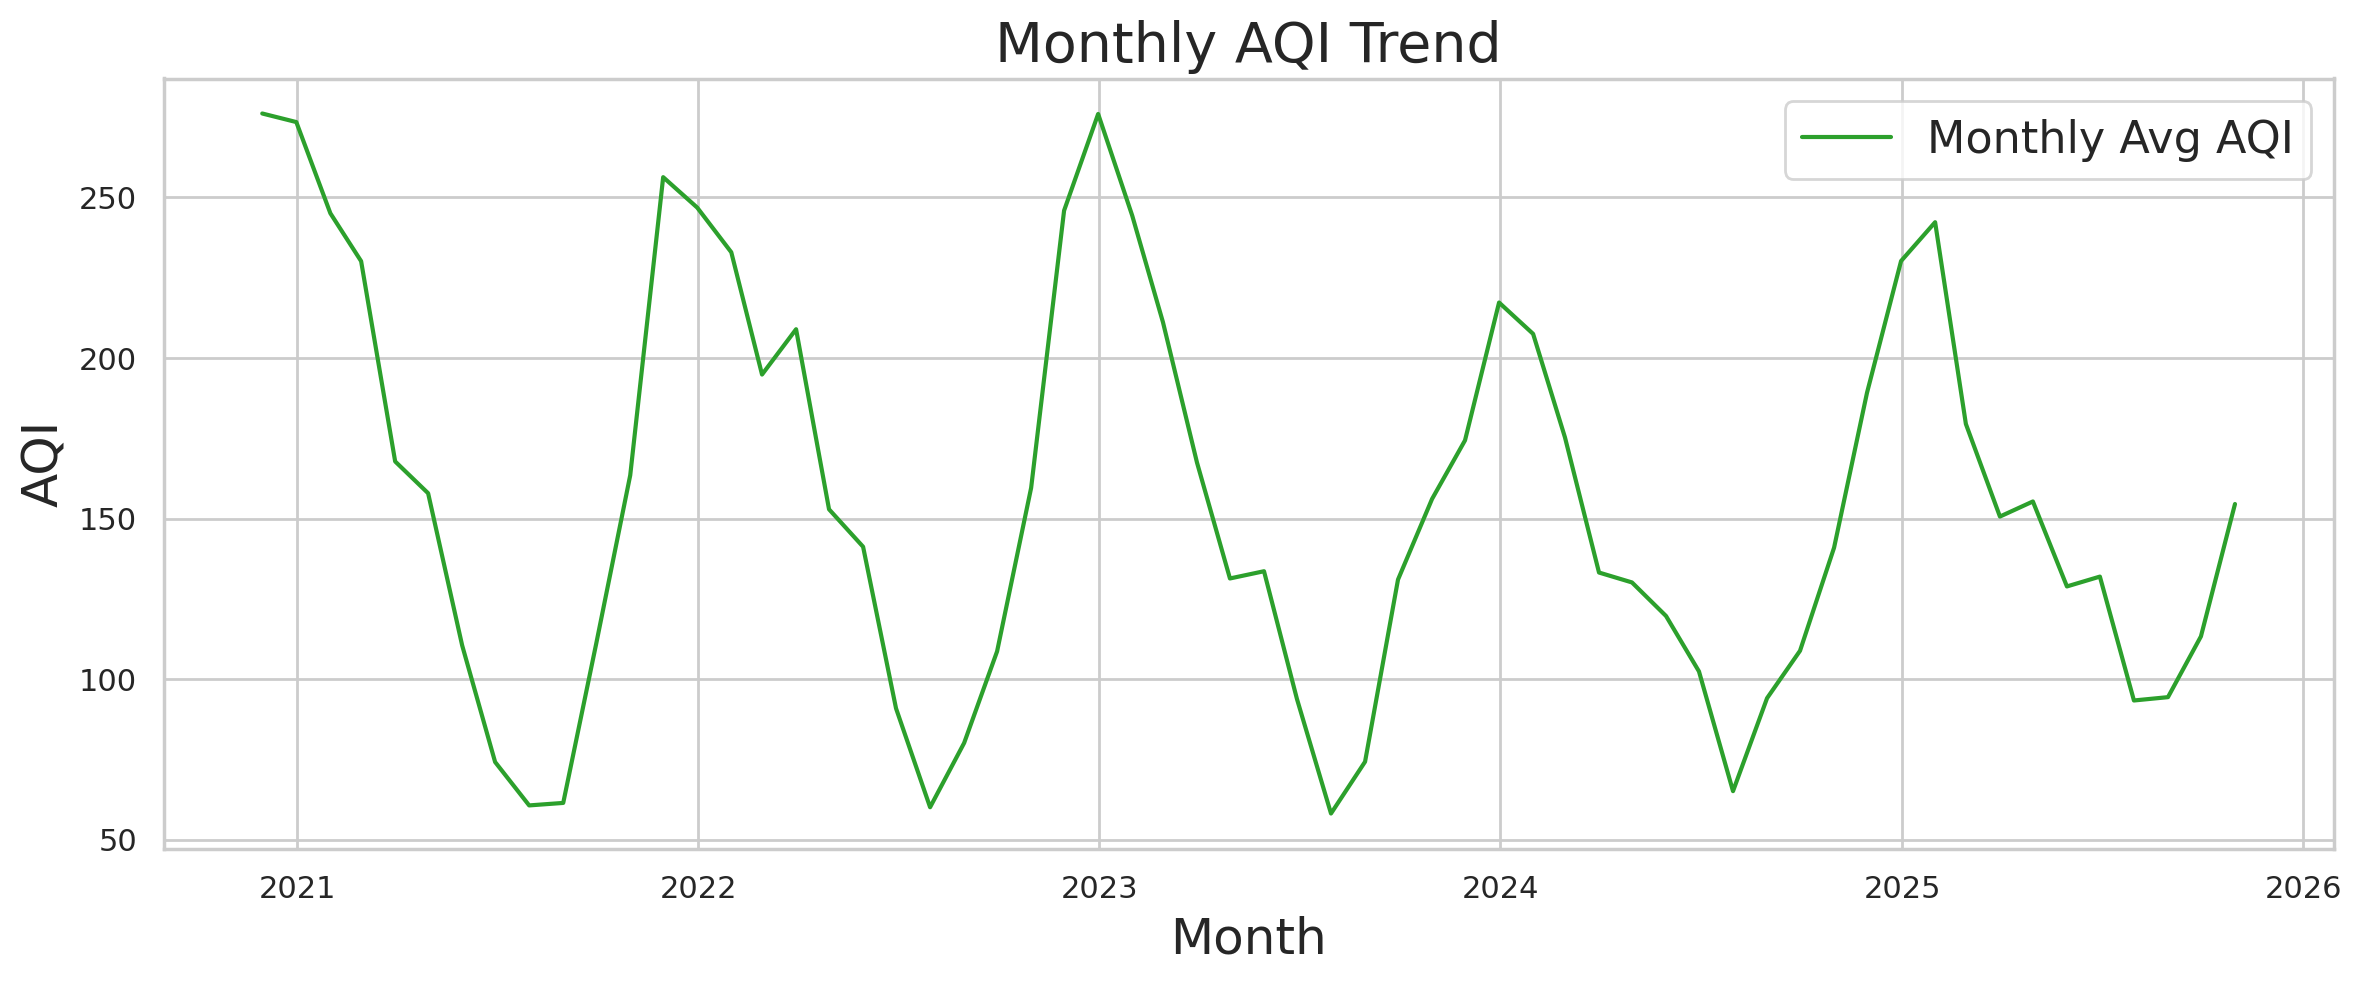

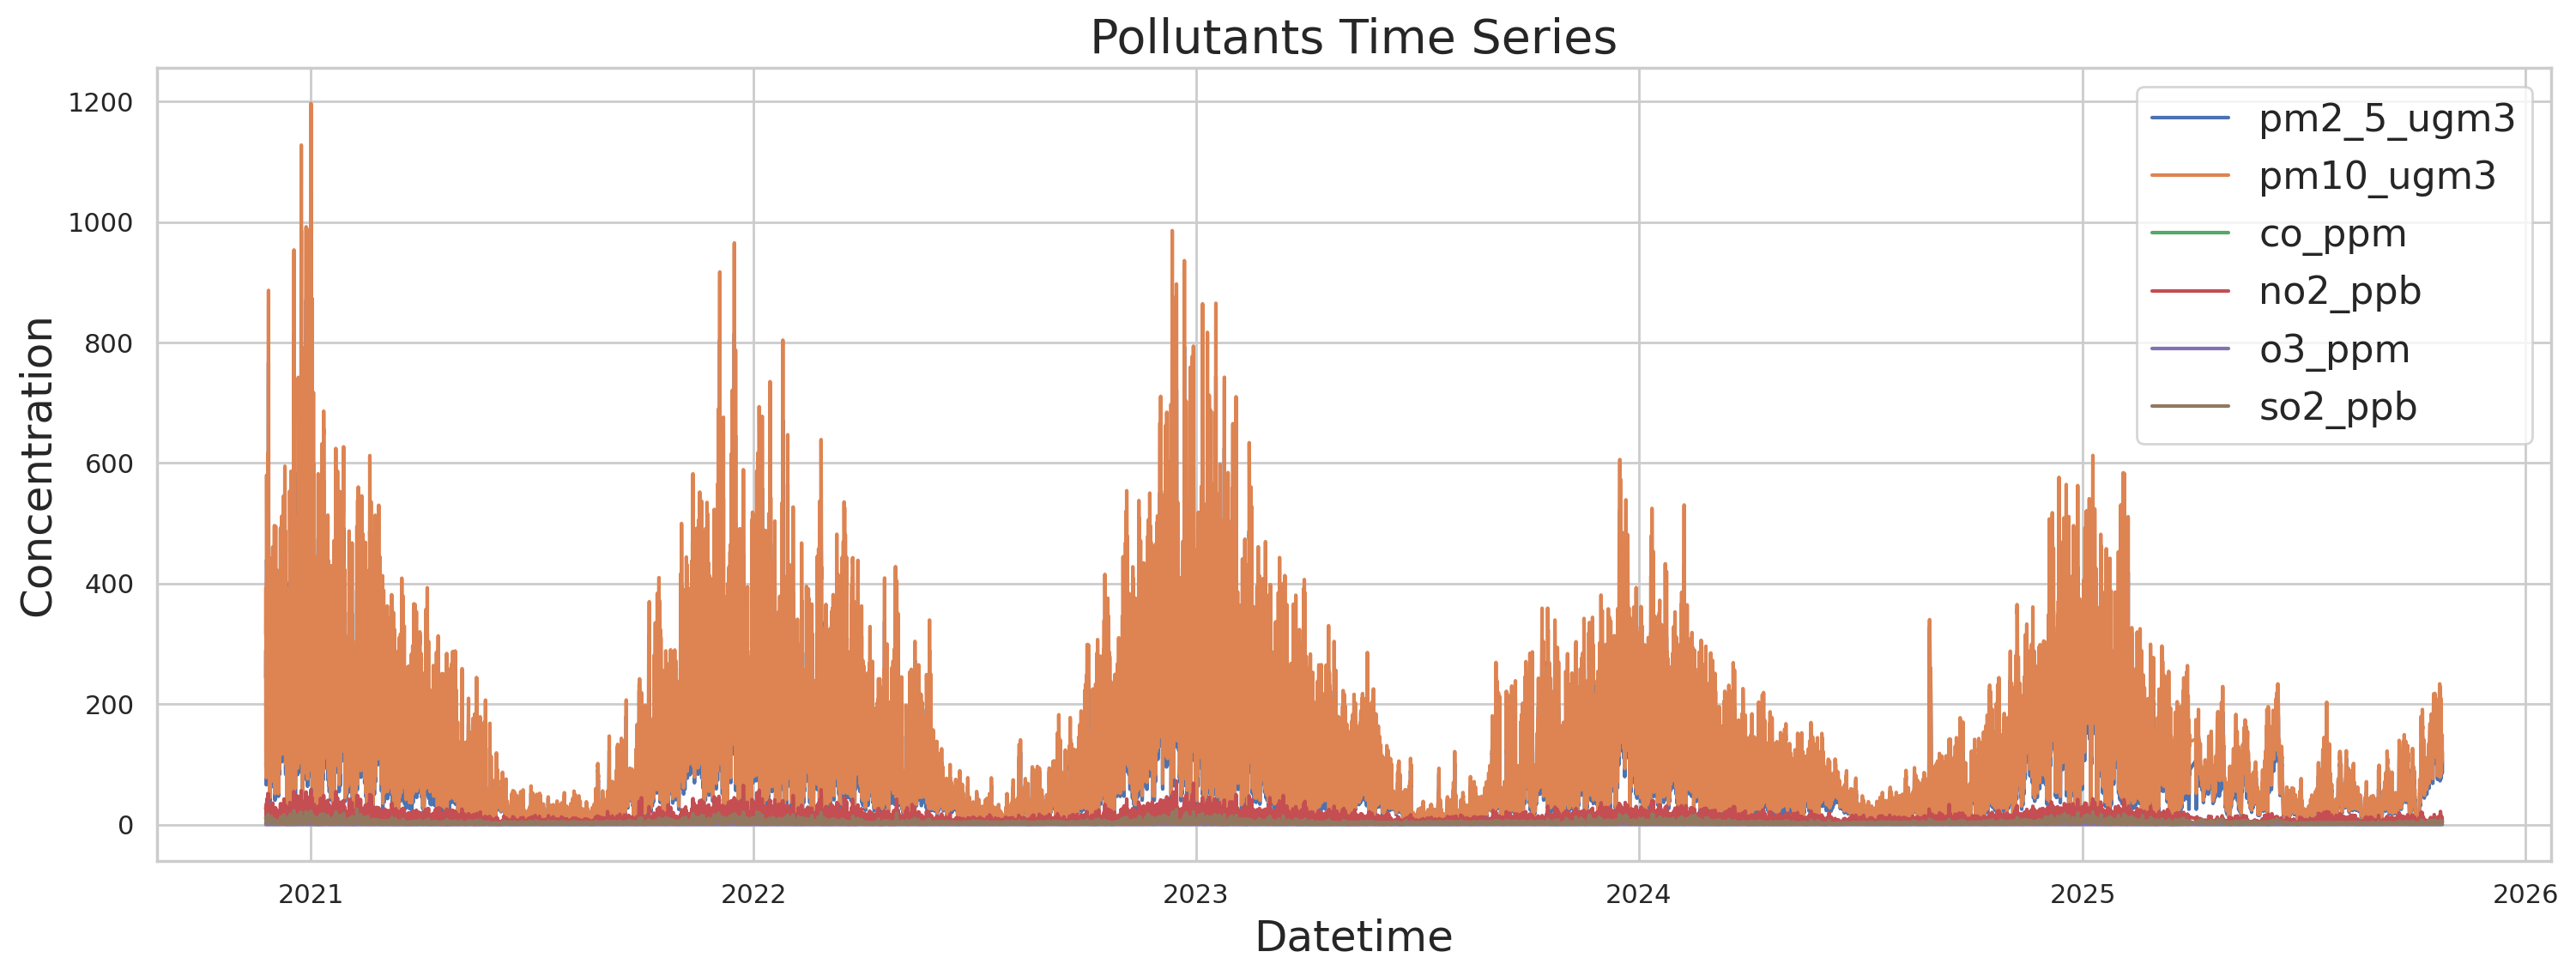

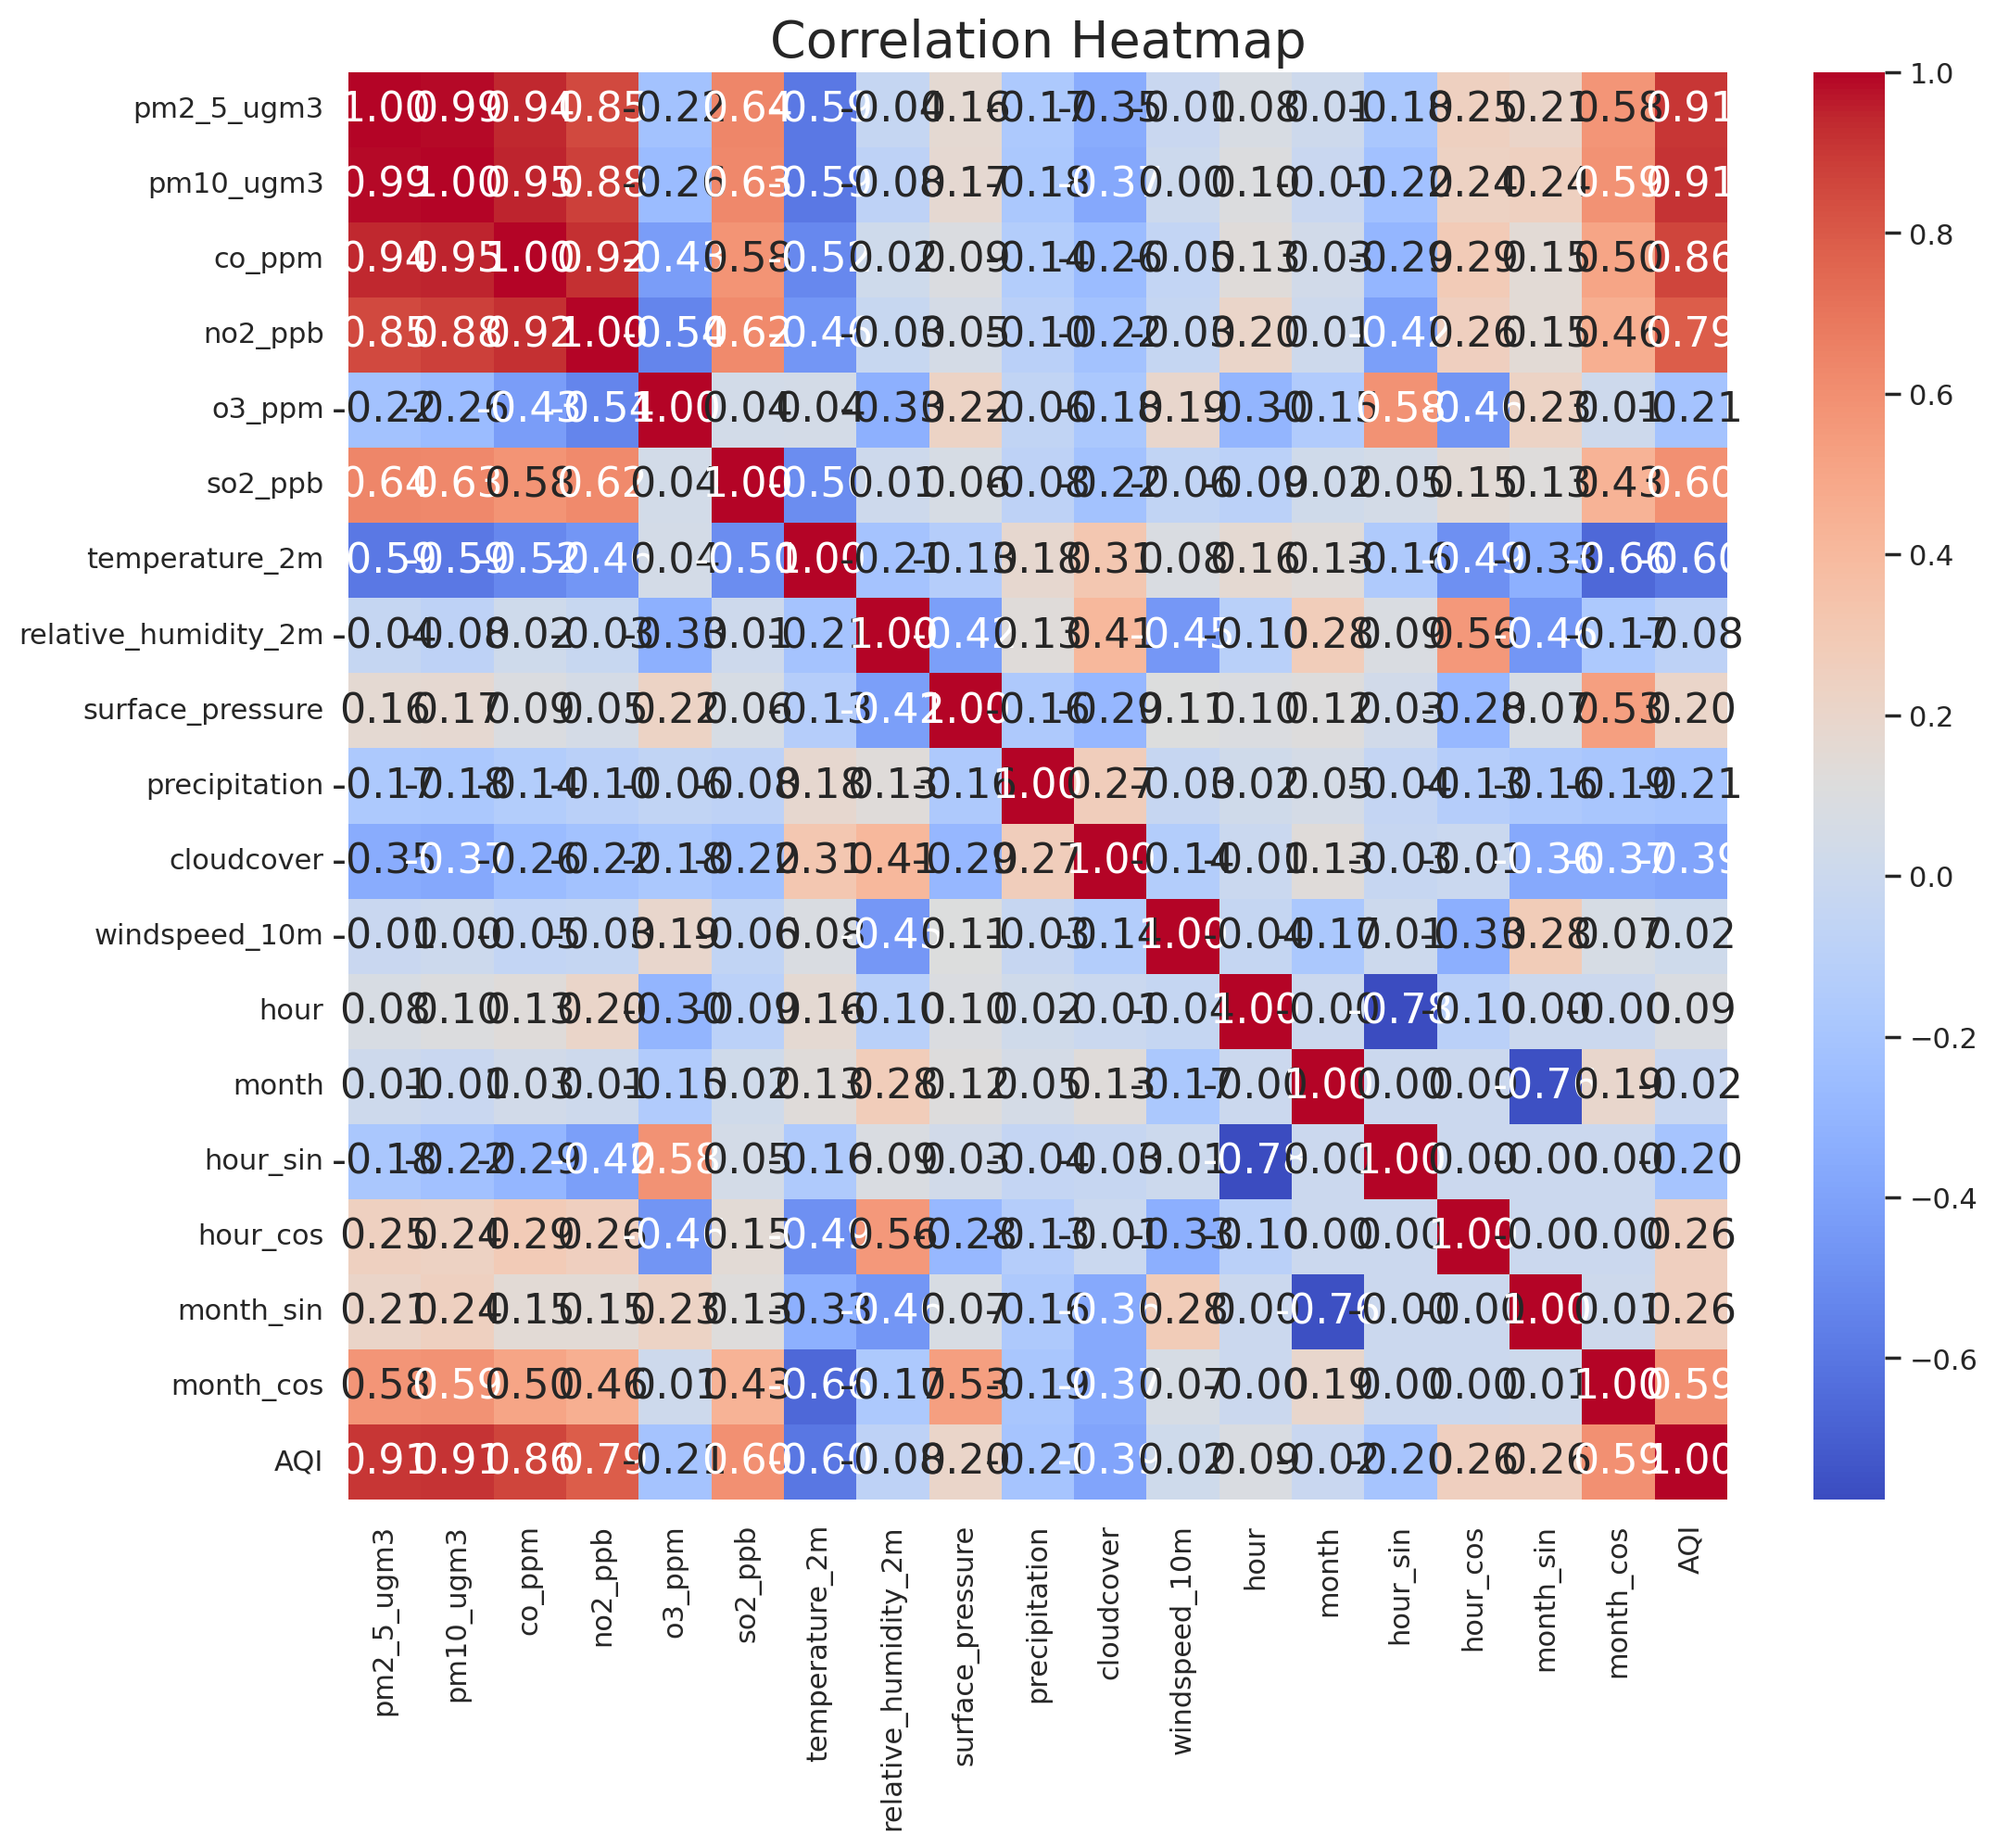

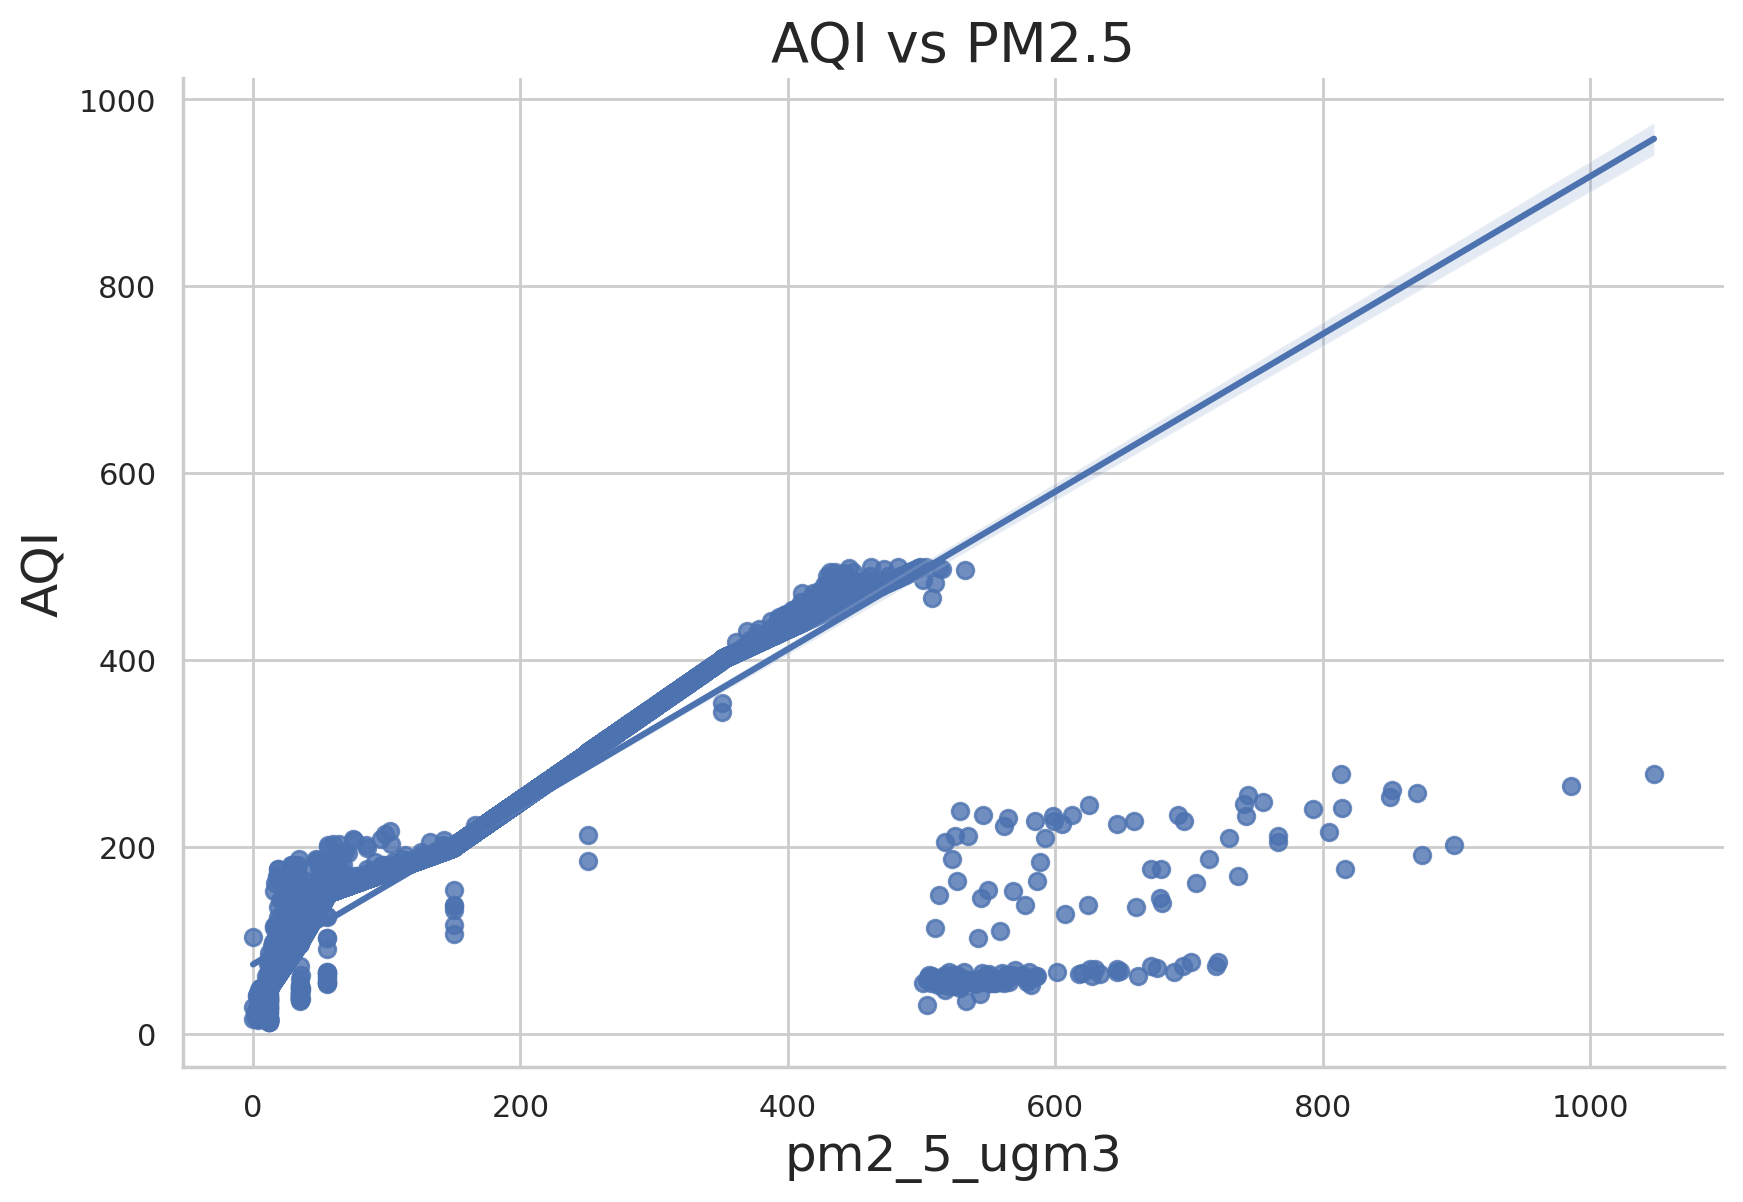

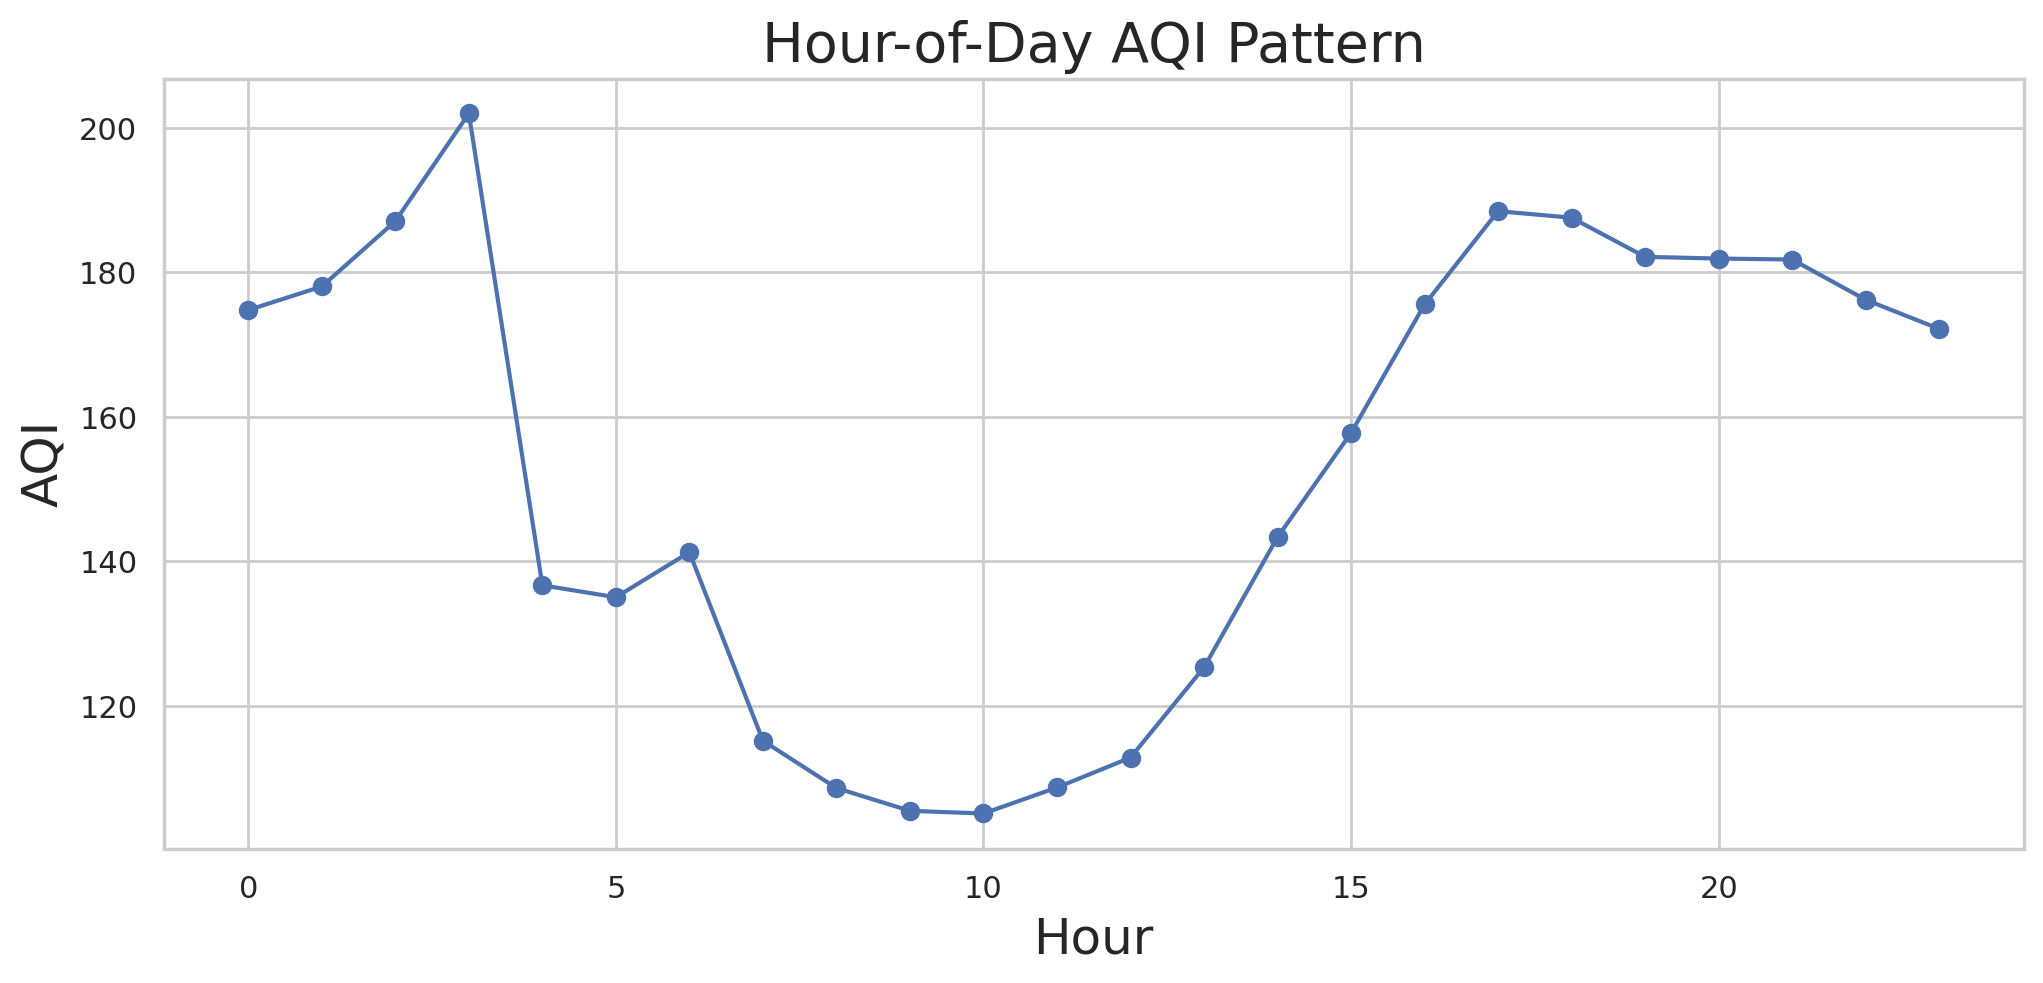

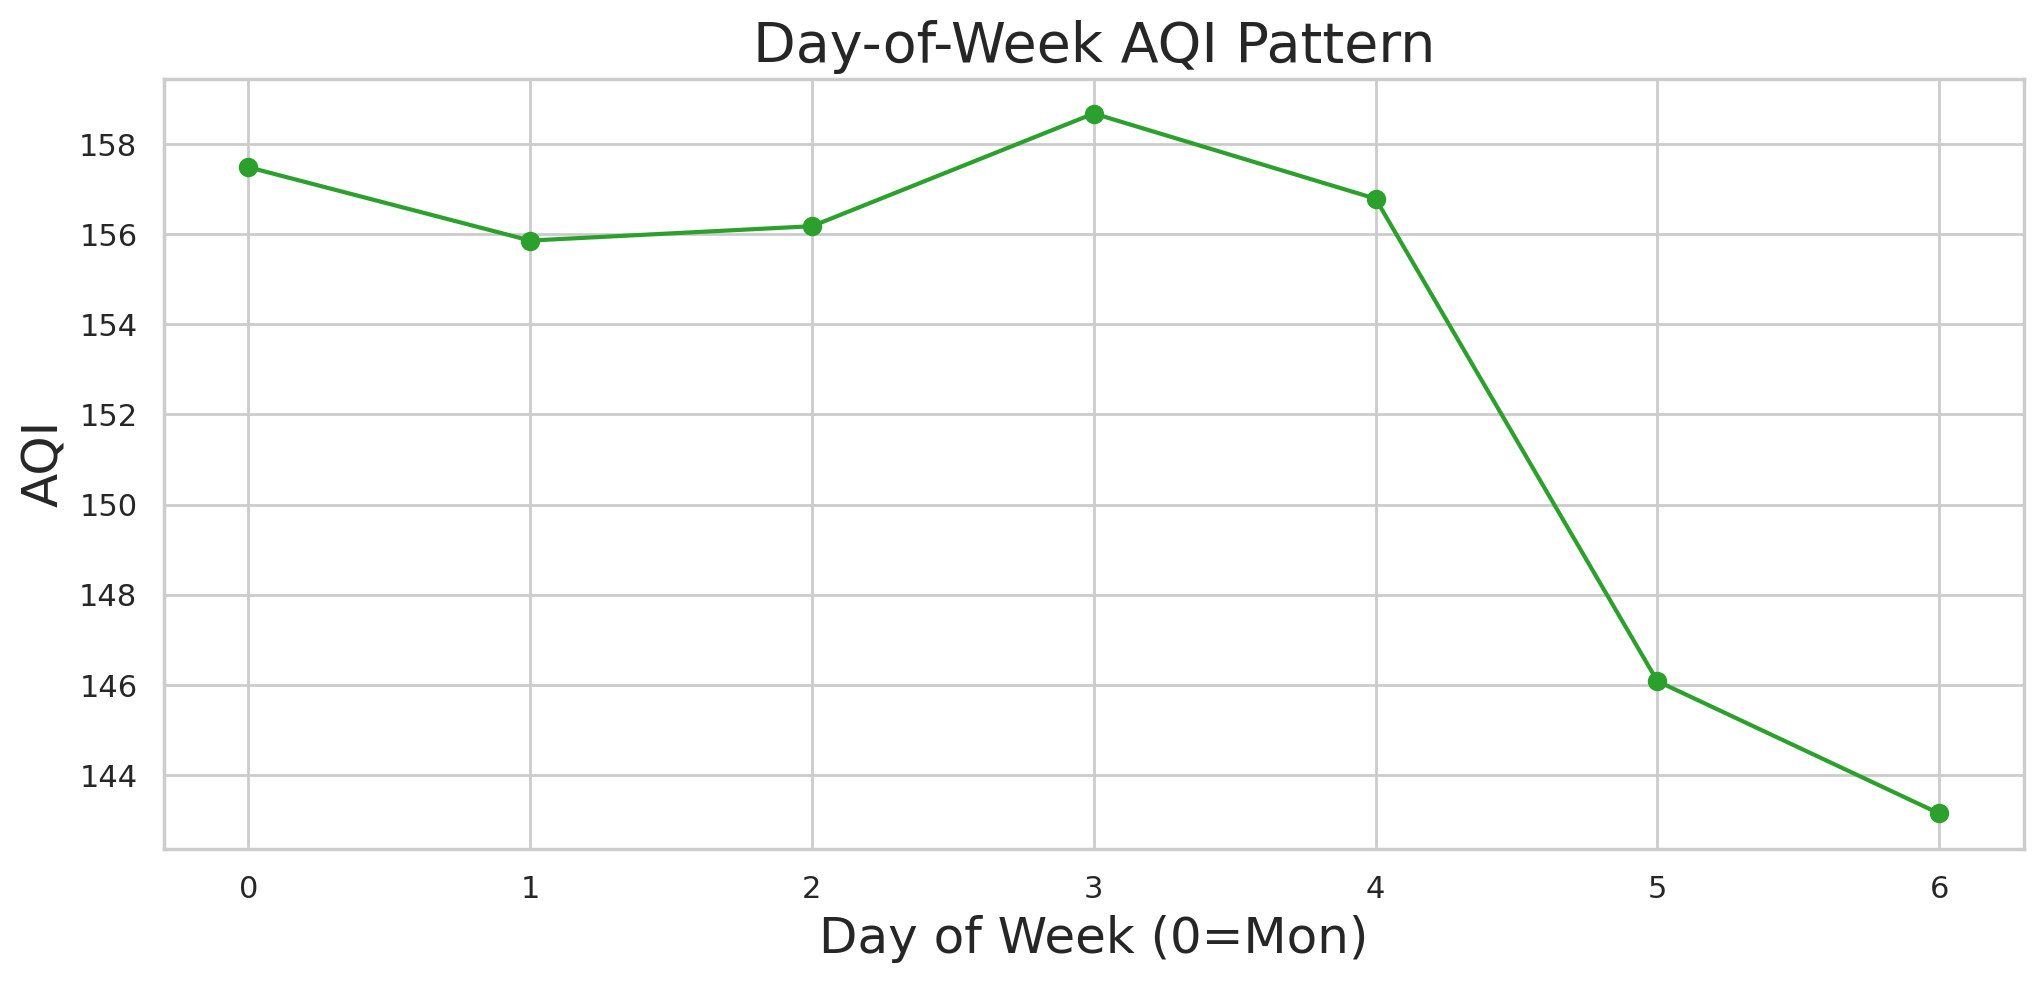

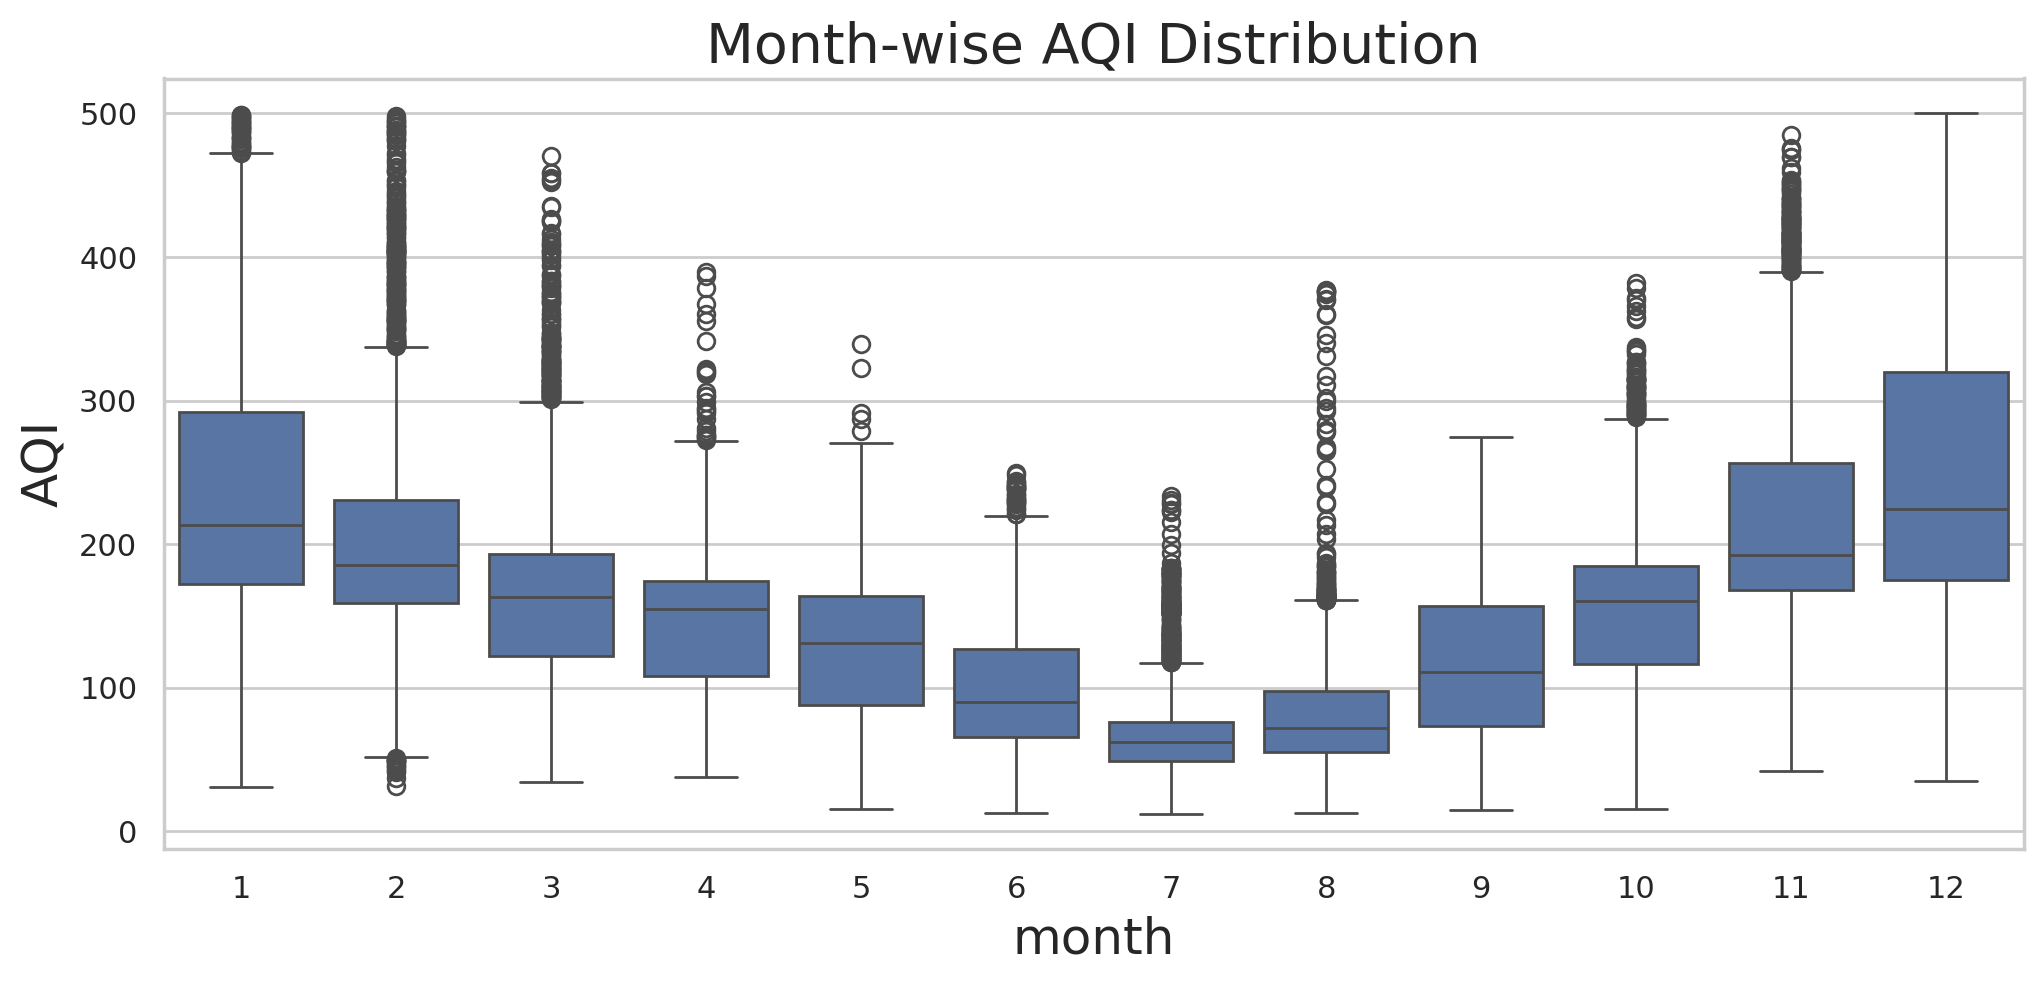

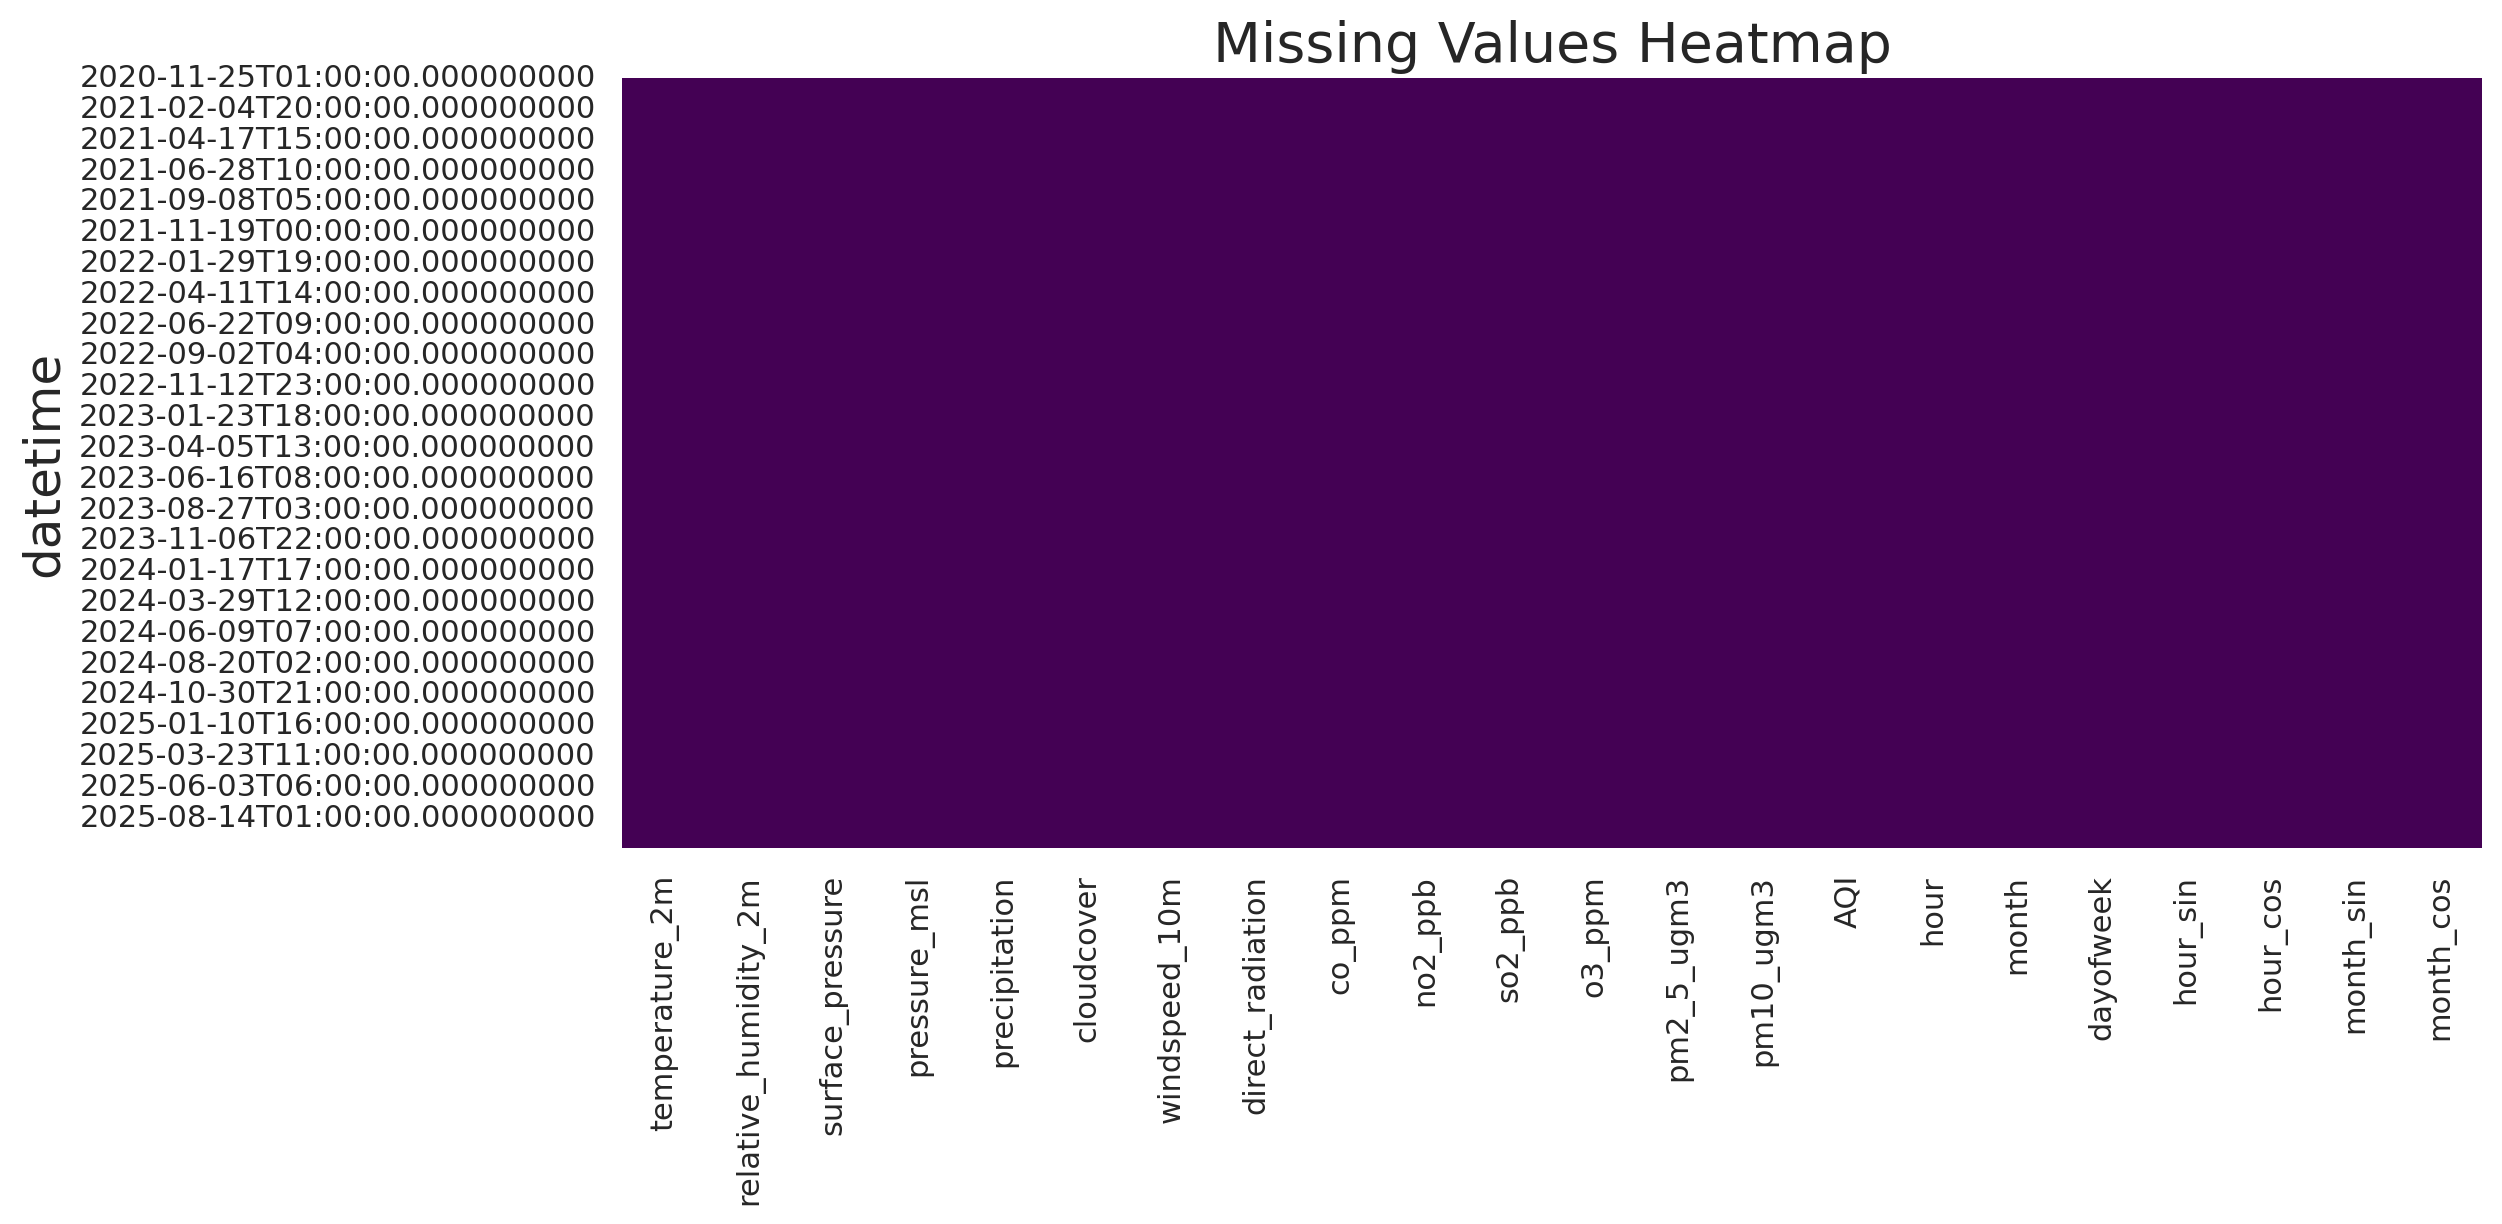

In [ ]:
# ============================================
# 📌 11. Publication-Quality Plots (High-Res)
# ============================================

# Hourly AQI
plt.figure(figsize=(18,5))
plt.plot(df.index, df["AQI"], label="Hourly AQI")
plt.title("Hourly AQI")
plt.xlabel("Datetime")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

# Daily AQI
daily_avg = df['AQI'].resample('D').mean()
plt.figure(figsize=(18,5))
plt.plot(daily_avg.index, daily_avg, color='tab:orange', label="Daily Avg AQI")
plt.title("Daily Average AQI")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

# Monthly AQI
monthly_avg = df['AQI'].resample('M').mean()
plt.figure(figsize=(14,5))
plt.plot(monthly_avg.index, monthly_avg, color='tab:green', label="Monthly Avg AQI")
plt.title("Monthly AQI Trend")
plt.xlabel("Month")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

# Multi-pollutant time series
plt.figure(figsize=(18,6))
for col, color in zip(['pm2_5_ugm3','pm10_ugm3','co_ppm','no2_ppb','o3_ppm','so2_ppb'],
                      ['tab:red','tab:blue','tab:orange','tab:purple','tab:green','tab:brown']):
    plt.plot(df.index, df[col], label=col)
plt.title("Pollutants Time Series")
plt.xlabel("Datetime")
plt.ylabel("Concentration")
plt.legend()
plt.grid(True)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df[feature_cols + ["AQI"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Scatter plots AQI vs PM2.5
sns.lmplot(x="pm2_5_ugm3", y="AQI", data=df, height=6, aspect=1.5)
plt.title("AQI vs PM2.5")
plt.show()

# Hour-of-day pattern
hourly_pattern = df.groupby('hour')['AQI'].mean()
plt.figure(figsize=(12,5))
plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o')
plt.title("Hour-of-Day AQI Pattern")
plt.xlabel("Hour")
plt.ylabel("AQI")
plt.grid(True)
plt.show()

# Day-of-week pattern
dow_pattern = df.groupby('dayofweek')['AQI'].mean()
plt.figure(figsize=(12,5))
plt.plot(dow_pattern.index, dow_pattern.values, marker='o', color='tab:green')
plt.title("Day-of-Week AQI Pattern")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("AQI")
plt.grid(True)
plt.show()

# Month-wise distribution
plt.figure(figsize=(12,5))
sns.boxplot(x='month', y='AQI', data=df)
plt.title("Month-wise AQI Distribution")
plt.show()

# Missing values heatmap
plt.figure(figsize=(12,5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

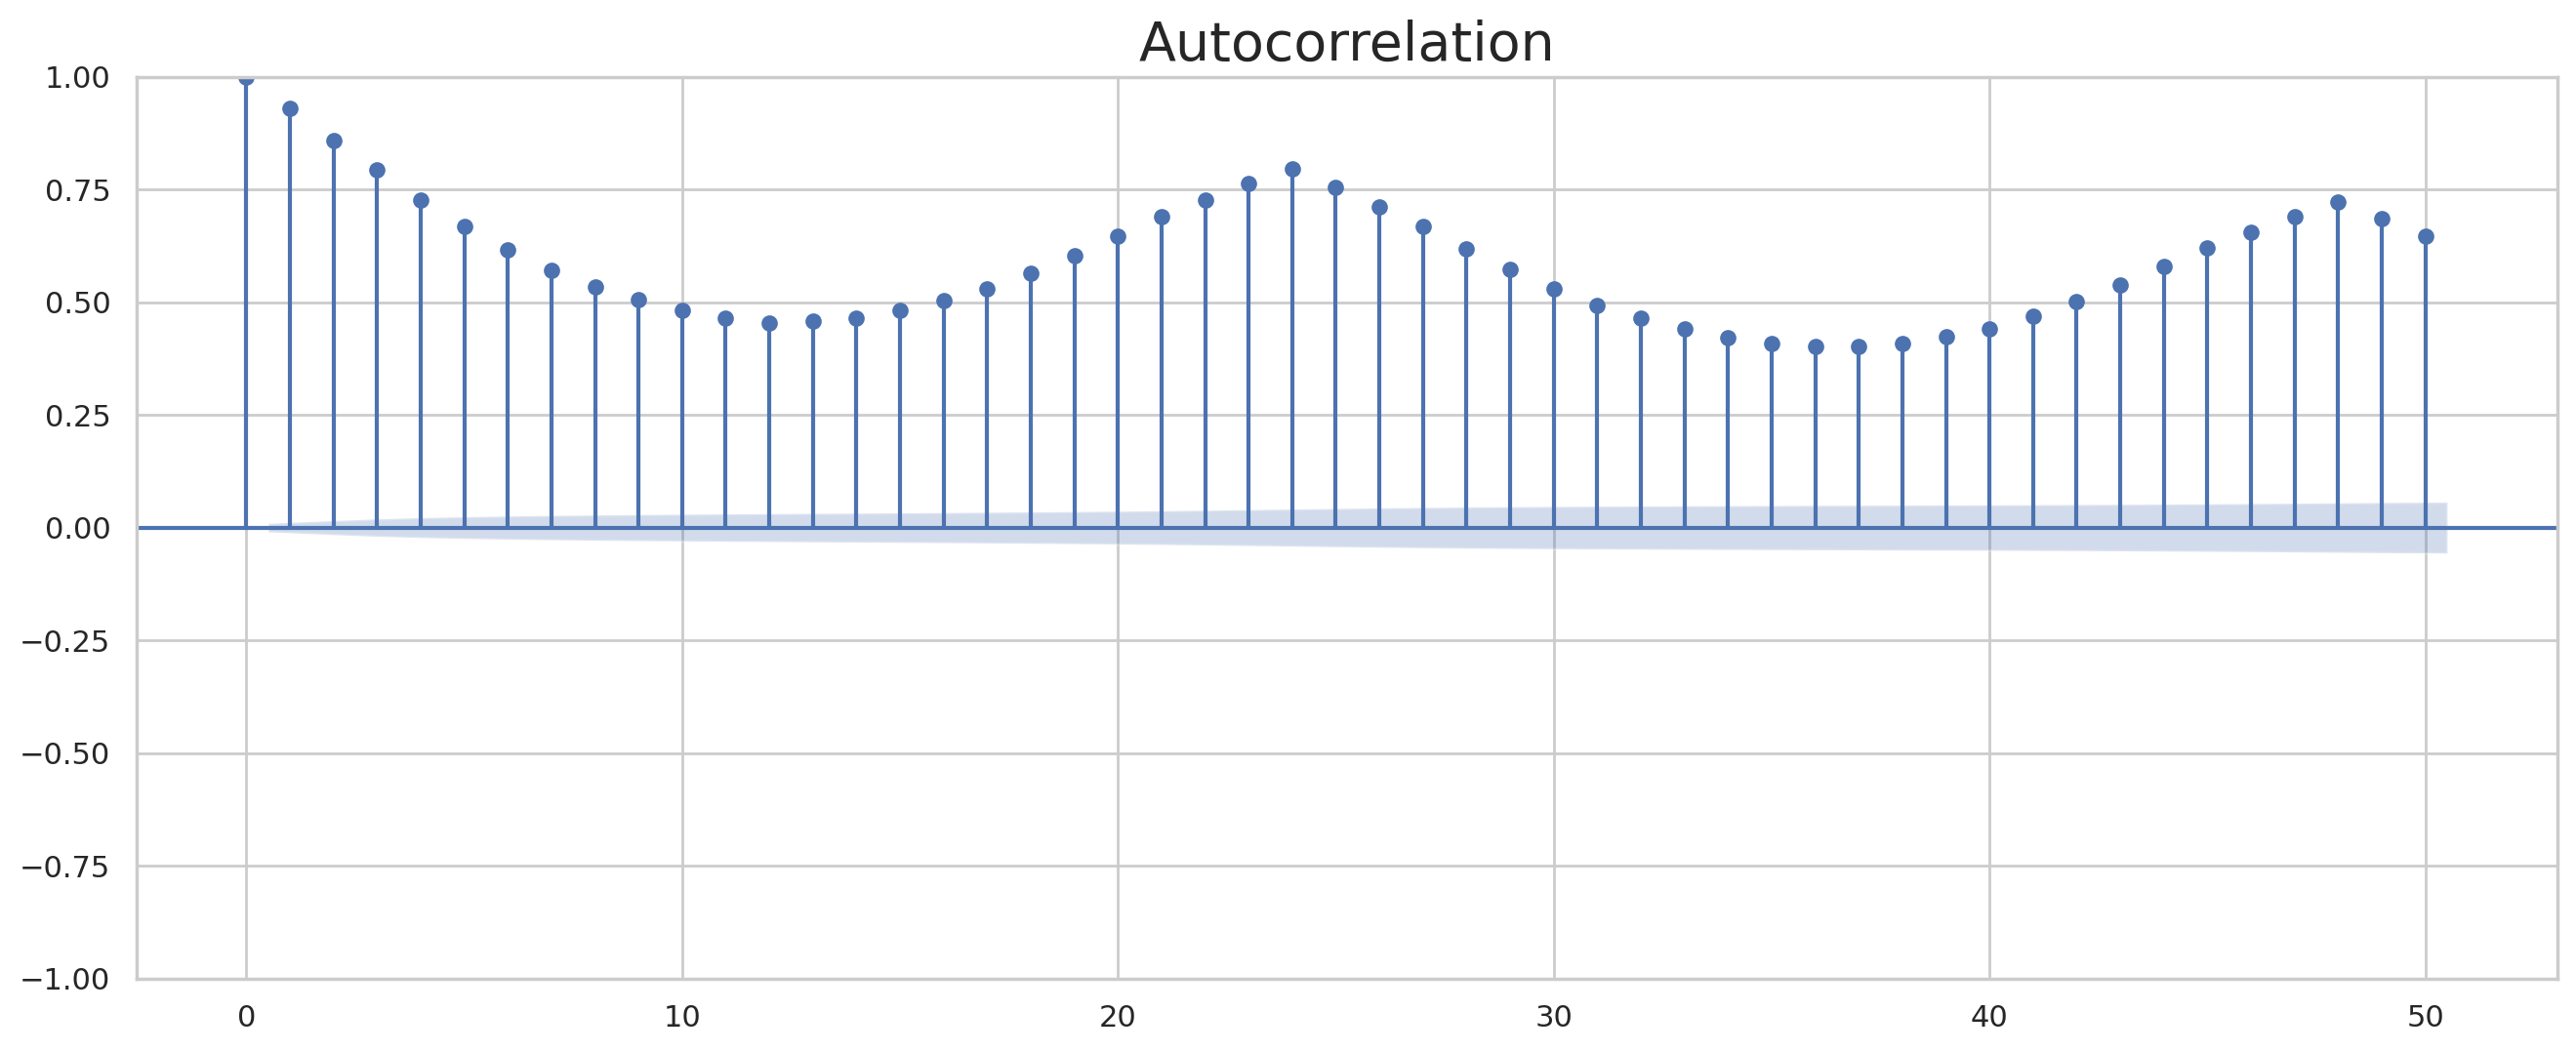

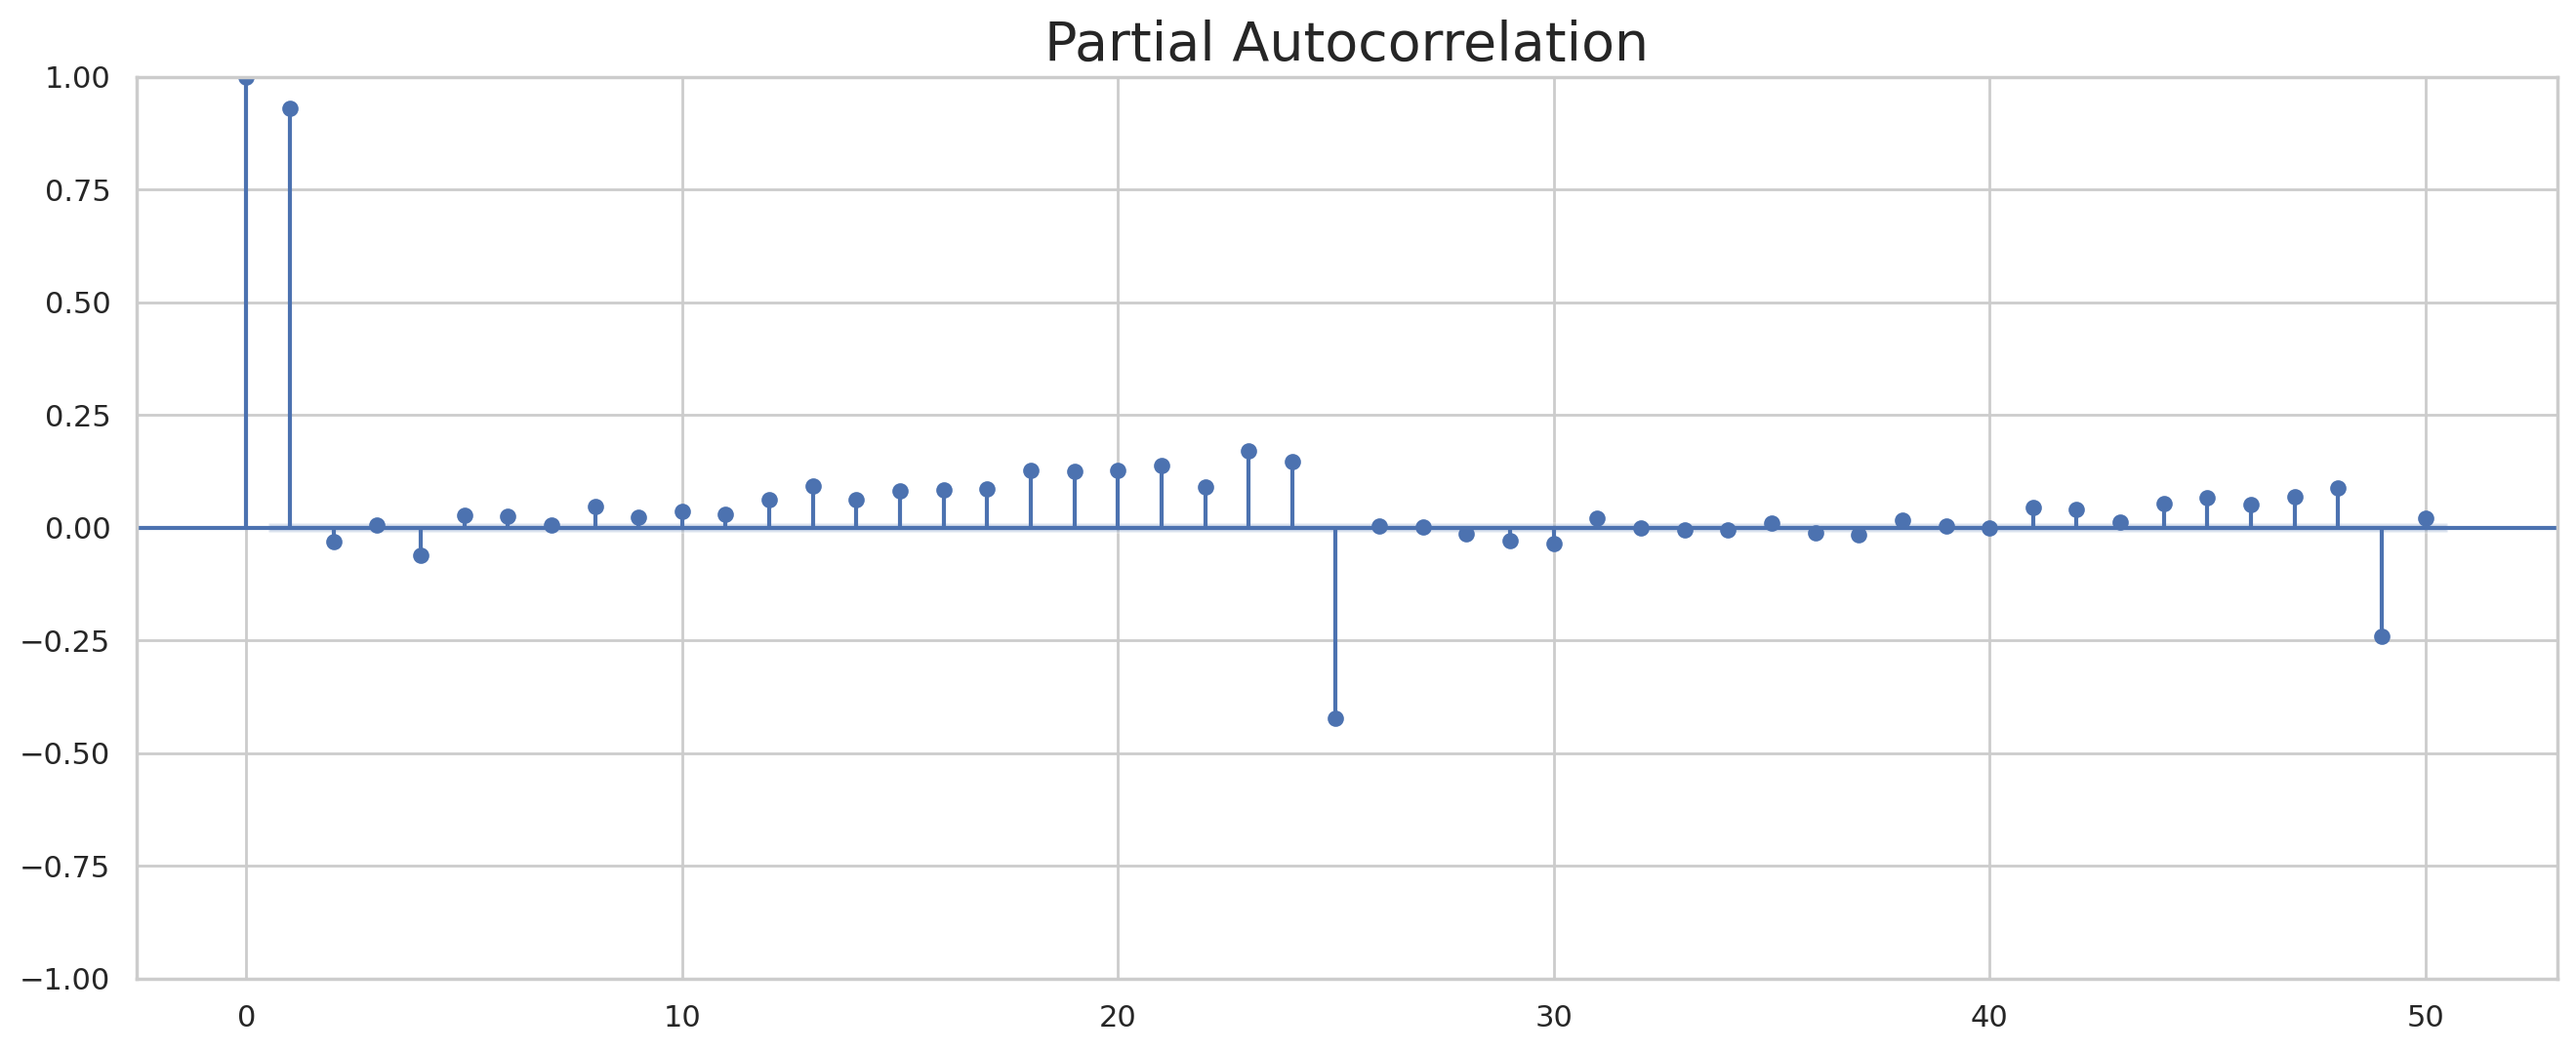

In [ ]:
# ============================================
# 📌 12. ACF / PACF
# ============================================
plot_acf(df["AQI"], lags=50)
plt.show()
plot_pacf(df["AQI"], lags=50)
plt.show()

In [ ]:
# ============================================
# 📌 13. Actual vs Predicted (Test Set)
# ============================================
plt.figure(figsize=(18,5))
plt.plot(y_test_true, label="Actual AQI")
plt.plot(y_test_pred, label="Predicted AQI", alpha=0.8)
plt.title("Test Set: Transformer Predicted vs Actual AQI")
plt.xlabel("Time Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

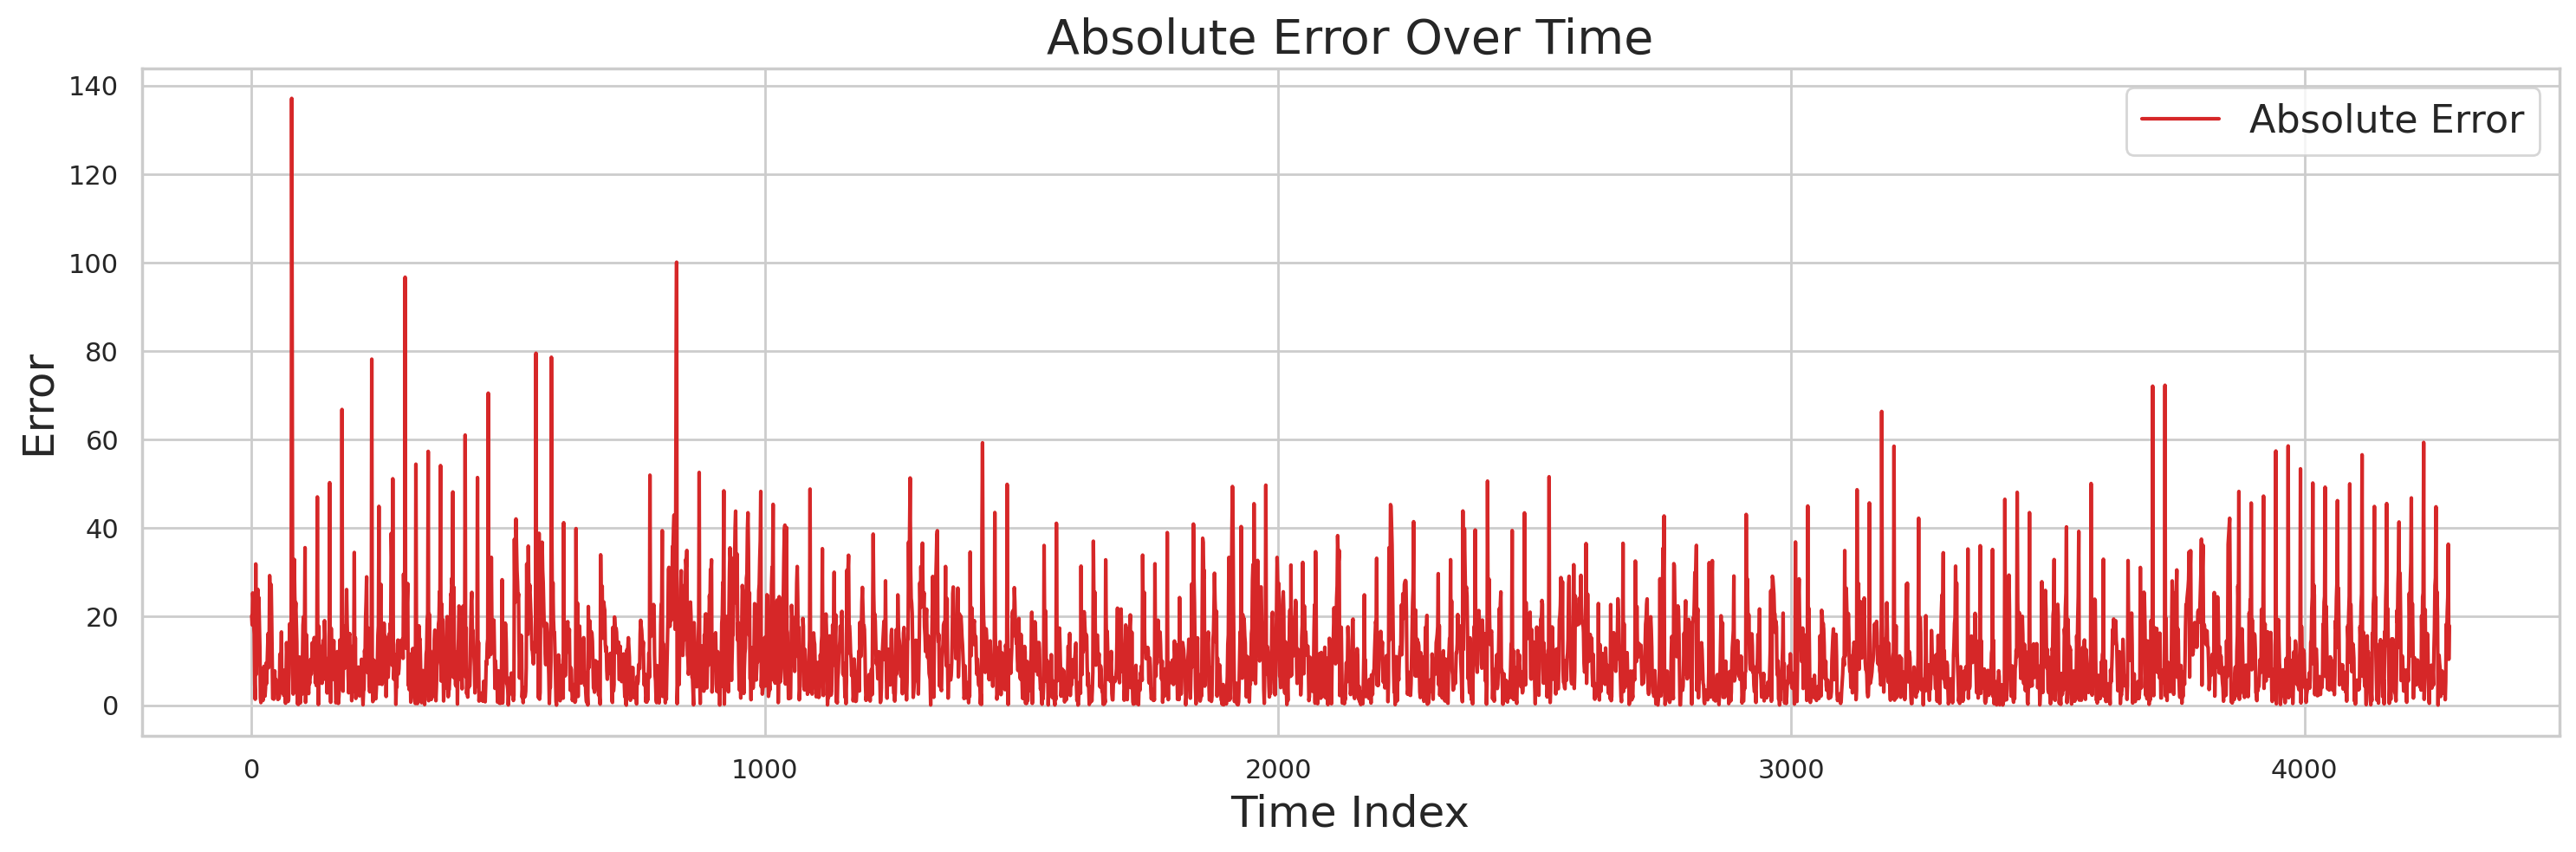

In [ ]:
# ============================================
# 📌 14. Error Analysis
# ============================================
abs_error = np.abs(y_test_true - y_test_pred)
squared_error = (y_test_true - y_test_pred)**2

plt.figure(figsize=(18,5))
plt.plot(abs_error, label="Absolute Error", color='tab:red')
plt.title("Absolute Error Over Time")
plt.xlabel("Time Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18,5))
plt.plot(squared_error, label="Squared Error", color='tab:orange')
plt.title("Squared Error Over Time")
plt.xlabel("Time Index")
plt.ylabel("Squared Error")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ============================================
# 📌 15. 24-Hour Rolling Forecast
# ============================================
y_pred_roll = []
X_roll = X_test_seq[0]  # first sequence
for i in range(len(X_test_seq)):
    pred = model.predict(X_roll[np.newaxis, ...])[0,0]
    y_pred_roll.append(pred)
    # roll the sequence
    if i+1 < len(X_test_seq):
        X_roll = np.vstack([X_roll[1:], X_test_seq[i+1][-1]])

y_pred_roll_inv = inverse_scale(np.array(y_pred_roll).reshape(-1,1))

plt.figure(figsize=(18,5))
plt.plot(y_test_true, label="Actual AQI")
plt.plot(y_pred_roll_inv, label="24-Hour Rolling Forecast", alpha=0.8)
plt.title("24-Hour Rolling Forecast vs Actual AQI")
plt.xlabel("Time Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

In [ ]:
# # ============================================
# # 📌 16. Example Inference from CSV
# # ============================================
# example = pd.read_csv("/content/example_input.csv")
# example["datetime"] = pd.to_datetime(example["datetime"])
# example = example.set_index("datetime")

# # Same feature engineering
# example["hour"] = example.index.hour
# example["month"] = example.index.month
# example["hour_sin"] = np.sin(2*np.pi*example["hour"]/24)
# example["hour_cos"] = np.cos(2*np.pi*example["hour"]/24)
# example["month_sin"] = np.sin(2*np.pi*example["month"]/12)
# example["month_cos"] = np.cos(2*np.pi*example["month"]/12)

# X_example = scaler_X.transform(example[feature_cols])

# # Convert to sequences
# X_example_seq = []
# for i in range(len(X_example)-SEQ_LEN):
#     X_example_seq.append(X_example[i:i+SEQ_LEN])
# X_example_seq = np.array(X_example_seq)

# example_preds = model.predict(X_example_seq)
# example["AQI_Predicted"] = np.nan
# example.iloc[SEQ_LEN:, example.columns.get_loc("AQI_Predicted")] = scaler_y.inverse_transform(example_preds).flatten()
# example.head()